In [76]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import os
import itertools
import yaml
import joblib
import dill 
import numpy as np
import scipy as sp 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.utils import shuffle
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import shap

In [79]:
from utils.utility import load_pickle, read_table_file, save_pickle, save_dataframe_dict
from evaluation.calibration import calibration_test
from evaluation.metrics import GroupModelMetric, ModelMetric, bootstrap_z_test
from training.model_training import run_automl_models
from evaluation.dca import plot_dca_curves
from evaluation.nri import calc_nri
from evaluation.bootstrap import compare_multi_groups, compare_pairwise

In [80]:
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Helvetica')
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = 'white'
sns.set_style(plt.rcParams)

In [8]:
work_dir = 'test/example'

# Model metric evaluation

## Load models and prediction results

In [9]:
_predict_results = load_pickle(os.path.join(work_dir, 'prediction.pkl'))
predict_train, predict_test = _predict_results['train'], _predict_results['test']
y_train, y_test = predict_train['label'], predict_test['label']


In [10]:
rf_components = load_pickle(os.path.join(work_dir, 'rf', 'rf_components.pkl'))
xgb_components = load_pickle(os.path.join(work_dir, 'xgboost', 'xgb_components.pkl'))
lr_components = load_pickle(os.path.join(work_dir, 'lr', 'lr_components.pkl'))


In [12]:

model_name_map = dict(
    zip(
        ['Caprini', 'Lasso', 'LR', 'XGB', 'XGB_Calib', 'RF', 'RF_Calib'],
        ['CRS', 'Lasso', 'LR', 'XGBoost', 'XGB', 'RandomForest', 'RF']
    )
)

models_list = ['Caprini', 'LR', 'XGB_Calib', 'RF_Calib']
models_mapped_list = [model_name_map[x] for x in models_list]


## Caprini variables and abbreviations

In [19]:
caprini_variables_raw = pd.read_excel(
    os.path.join(work_dir, 'CapriniVariables.xlsx'), 
    sheet_name='CapriniVariables', usecols='A:C,E', header=1
)
caprini_feats_map = dict(zip(caprini_variables_raw['raw_name'], caprini_variables_raw['Abbreviation']))
caprini_variables_raw.head()

,Abbreviation,raw_name,Caprini variables,Score
0,VVV,AF_VVV,visible varicose veins,1
1,Immobilization,AF_IPC,non-removable plaster cast or mold than has ke...,2
2,LungDisease,AF_PulmonaryDisease,lung disease,1
3,CHF,AF_CHF,congestive heart failure,1
4,THA&TKA,AF_TKA,elective hip or knee joint replacement surgery,5


### SubTable 1

In [21]:

caprini_variables_df = caprini_variables_raw.iloc[:, [0, 2, 3]].copy()
caprini_variables_df.sort_values(['Score', 'Abbreviation'], inplace=True)
caprini_variables_df

,Abbreviation,Caprini variables,Score
16,AdvPregnancy,"history of unexplained stillborn infant, recur...",1
23,BC&HRT,current use of birth control or hormone replac...,1
3,CHF,congestive heart failure,1
10,HeartAttack,heart attack,1
21,IBD,a history of inflammatory bowel disease,1
2,LungDisease,lung disease,1
27,MajorSurg,length of a surgery over 2 hours,1
17,MinSurg,minor surgery (<45min) is planned,1
22,Obesity,overweight or obese,1
8,PastMajorSurg,past major surgery (>45 min) within last month,1


In [ ]:
caprini_variables_df.to_excel(
    os.path.join(work_dir, 'fig_tab', 'Caprini_features.xlsx'), index=False
)

## Model variables infomation

In [13]:
lr_model = lr_components['lr_by_lasso']
rf_model = rf_components['rf1_calibrator']
xgb_model = xgb_components['xgb1_calibrator']
rf_raw_model = rf_components['rf1']
xgb_raw_model = xgb_components['xgb1']

In [14]:
lr_coef = pd.Series(lr_model.coef_.flatten(), index=lr_components['features_lasso'])
rf_imp = pd.Series(rf_raw_model.feature_importances_, index=rf_components['features_rf1'])
xgb_imp = pd.Series(xgb_raw_model.feature_importances_, index=xgb_components['features_xgb1'])

In [15]:
lr_coef.loc[np.abs(lr_coef) < 1e-8] = np.nan


In [22]:
model_info_df = pd.DataFrame(
    np.nan, index=list(caprini_feats_map.keys()), 
    columns=['Variables', 'LR_Coef', 'RF_Feat_Imp', 'XGB_Feat_Imp']
)
model_info_df['Variables'] = model_info_df.index.map(caprini_feats_map)
model_info_df.loc[lr_coef.index, 'LR_Coef'] = lr_coef
model_info_df.loc[rf_imp.index, 'RF_Feat_Imp'] = rf_imp
model_info_df.loc[xgb_imp.index, 'XGB_Feat_Imp'] = xgb_imp


### SubTable 3

In [ ]:
model_info_df1 = model_info_df.copy()
model_info_df1.loc[cols_minor, ['LR_Coef', 'RF_Feat_Imp', 'XGB_Feat_Imp']] = np.nan

model_info_disp_df1 = model_info_df1.set_index('Variables').loc[caprini_variables_df['Abbreviation'].iloc[::-1]].round(4)
model_info_disp_df1.fillna('/', inplace=True)
model_info_disp_df1

LR_Coef         15
RF_Feat_Imp     15
XGB_Feat_Imp    14
dtype: int64


,LR_Coef,RF_Feat_Imp,XGB_Feat_Imp
Variables,,,
Bedridden,0.4741,0.18,0.1137
Age,0.653,0.0883,0.0462
THA&TKA,-0.2944,/,0.0415
Stroke,0.4031,0.043,0.0269
SpinalCordInjury,/,/,/


In [ ]:
save_dataframe_dict(
    {'model_info': model_info_disp_df, 'model_info1': model_info_disp_df1}, 
    file=os.path.join(work_dir, 'fig_tab', 'model_feature_info.xlsx'),
    index=True
)

## Discrimination: 

AUROC, PRC, F1, Sensitivity, Specificity
Selected features

In [17]:
metric_disp = ('AUROC', 'AUPRC', 'Sensitivity', 'Specificity', 'Precision', 'F1')


In [91]:
%%time

group_metrics_train = GroupModelMetric(
    y_train, predict_train[models_list], 
    model_name_map=model_name_map, auto_set_cutoff=True
)
metric_value_train = group_metrics_train.get_metric_summary_df(metric_names=metric_disp)


CPU times: user 1.55 s, sys: 15.9 ms, total: 1.56 s
Wall time: 1.58 s


In [92]:
%%time

group_metrics_test = GroupModelMetric(
    y_test, predict_test[models_list], 
    model_name_map=model_name_map, best_cutoffs=group_metrics_train.best_cutoffs
)
metric_value_test = group_metrics_test.get_metric_summary_df(metric_names=metric_disp)


CPU times: user 626 ms, sys: 5.56 ms, total: 632 ms
Wall time: 635 ms


In [93]:
%%time

metric_std_train, metric_ci_low_train, metric_ci_upp_train, metric_boot_train = \
    group_metrics_train.bootstrap_statistics(metric_disp, n_boot=5000, n_jobs=-1)


CPU times: user 44 s, sys: 2.4 s, total: 46.4 s
Wall time: 17min 21s


In [94]:
%%time

metric_std_test, metric_ci_low_test, metric_ci_upp_test, metric_boot_test = \
    group_metrics_test.bootstrap_statistics(metric_disp, n_boot=5000, n_jobs=-1)


CPU times: user 44.4 s, sys: 1.57 s, total: 46 s
Wall time: 7min 13s


In [ ]:
# or load existed files

metric_stat_train = load_pickle(os.path.join(work_dir, 'metric_statistics_train.pkl'))
metric_value_train = metric_stat_train['value']
metric_std_train = metric_stat_train['std']
metric_ci_low_train, metric_ci_upp_train = metric_stat_train['ci_lower'], metric_stat_train['ci_upper']
metric_boot_train = metric_stat_train['details']

metric_stat_test = load_pickle(os.path.join(work_dir, 'metric_statistics_test.pkl'))
metric_value_test = metric_stat_test['value']
metric_std_test = metric_stat_test['std']
metric_ci_low_test, metric_ci_upp_test = metric_stat_test['ci_lower'], metric_stat_test['ci_upper']
metric_boot_test = metric_stat_test['details']


,CRS,LR,XGB,RF
AUROC,0.713647,0.797850,0.797588,0.803670
AUPRC,0.180038,0.303214,0.352266,0.360188
Sensitivity,0.886076,0.797468,0.772152,0.810127
Specificity,0.430769,0.714793,0.700592,0.687574
Precision,0.127042,0.207237,0.194268,0.195122
F1,0.222222,0.328982,0.310433,0.314496


### Table 2: metric display

In [ ]:
# metric display

metric_disp_test = pd.DataFrame(
    np.nan, columns=metric_value_test.columns, index=metric_value_test.index, dtype=str
)
for _idx, _col in itertools.product(metric_value_test.index, metric_value_test.columns):
    _val = metric_value_test.loc[_idx, _col]
    _ci_l = metric_ci_low_test.loc[_idx, _col]
    _ci_u = metric_ci_upp_test.loc[_idx, _col]
    metric_disp_test.loc[_idx, _col] = f"{_val:0.3f}\n({_ci_l:0.3f}, {_ci_u:0.3f})"
metric_disp_test

,CRS,LR,XGB,RF
AUROC,"0.714\n(0.656, 0.767)","0.798\n(0.745, 0.845)","0.798\n(0.745, 0.846)","0.804\n(0.750, 0.852)"
AUPRC,"0.180\n(0.133, 0.247)","0.303\n(0.227, 0.415)","0.352\n(0.261, 0.452)","0.360\n(0.268, 0.464)"
Sensitivity,"0.886\n(0.595, 0.797)","0.797\n(0.709, 0.886)","0.772\n(0.671, 0.861)","0.810\n(0.722, 0.886)"
Specificity,"0.431\n(0.585, 0.650)","0.715\n(0.646, 0.708)","0.701\n(0.669, 0.730)","0.688\n(0.656, 0.718)"
Precision,"0.127\n(0.124, 0.167)","0.207\n(0.166, 0.210)","0.194\n(0.170, 0.219)","0.195\n(0.173, 0.218)"
F1,"0.222\n(0.205, 0.275)","0.329\n(0.270, 0.338)","0.310\n(0.272, 0.347)","0.314\n(0.280, 0.349)"


In [ ]:
metric_disp_test.to_excel(os.path.join(work_dir, 'metric_test.xlsx'))

In [ ]:
# Pairwise comparison
metric_compare_test = dict()

for _metric_idx, _metric in enumerate(metric_disp):
    _p_compare = pd.DataFrame(np.nan, index=models_mapped_list, columns=models_mapped_list)
    _z_compare = pd.DataFrame(np.nan, index=models_mapped_list, columns=models_mapped_list)
    for _model_idx1, _model1 in enumerate(models_mapped_list):
        for _model_idx2, _model2 in enumerate(models_mapped_list):
            if _model_idx1 == _model_idx2:
                _p, _z = 1.0, 0.0
            else:
                _p, _z = bootstrap_z_test(
                    metric_value_test.iloc[_metric_idx, _model_idx1] - metric_value_test.iloc[_metric_idx, _model_idx2],
                    metric_boot_test[:, _metric_idx, _model_idx1] - metric_boot_test[:, _metric_idx, _model_idx2],
                    alternative='one_sided'
                )
            _p_compare.loc[_model1, _model2] = _p
            _z_compare.loc[_model1, _model2] = _z
    metric_compare_test[_metric] = [_p_compare, _z_compare]


In [ ]:
pd.concat([_p_compare, pd.Series([np.nan] * len(_p_compare), index=_p_compare.index), _z_compare], axis=1)

,Caprini,LogisticRegression,XGBoost,RandomForest,0,Caprini,LogisticRegression,XGBoost,RandomForest
Caprini,1.000000,0.001903,0.000381,0.000125,NaN,0.000000,-2.893843,-3.366098,-3.661777
LogisticRegression,0.001903,1.000000,0.126345,0.029121,NaN,2.893843,0.000000,-1.143840,-1.893877
XGBoost,0.000381,0.126345,1.000000,0.255577,NaN,3.366098,1.143840,0.000000,-0.657042
RandomForest,0.000125,0.029121,0.255577,1.000000,NaN,3.661777,1.893877,0.657042,0.000000


In [ ]:
# string display

metric_display_test = pd.DataFrame(None, index=metric_value_test.index, columns=metric_value_test.columns)
for _col in metric_display_test.columns:
    for _idx in metric_display_test.index:
        metric_display_test.loc[_idx, _col] = f"{metric_value_test.loc[_idx, _col]:.3f} ({metric_std_test.loc[_idx, _col]:.3f})"
metric_display_test

,Caprini,LogisticRegression,XGBoost,RandomForest
AUROC,0.714 (0.028),0.798 (0.026),0.798 (0.026),0.804 (0.026)
AUPRC,0.180 (0.029),0.303 (0.048),0.352 (0.049),0.360 (0.050)
Sensitivity,0.886 (0.053),0.797 (0.045),0.772 (0.047),0.810 (0.044)
Specificity,0.431 (0.017),0.715 (0.016),0.701 (0.016),0.688 (0.016)
Precision,0.127 (0.011),0.207 (0.011),0.194 (0.013),0.195 (0.012)
F1,0.222 (0.018),0.329 (0.018),0.310 (0.019),0.314 (0.018)
Youden,0.317 (0.055),0.512 (0.048),0.473 (0.050),0.498 (0.047)
AP,0.176 (0.027),0.311 (0.047),0.345 (0.049),0.355 (0.050)


In [ ]:
metric_display_train = pd.DataFrame(None, index=metric_value_train.index, columns=metric_value_train.columns)
for _col in metric_display_train.columns:
    for _idx in metric_display_train.index:
        metric_display_train.loc[_idx, _col] = f"{metric_value_train.loc[_idx, _col]:.3f} ({metric_std_train.loc[_idx, _col]:.3f})"
metric_display_train

,CRS,LR,XGB,RF
AUROC,0.713 (0.018),0.798 (0.017),0.826 (0.016),0.812 (0.016)
AUPRC,0.160 (0.014),0.335 (0.034),0.418 (0.035),0.414 (0.035)
Sensitivity,0.723 (0.033),0.788 (0.030),0.777 (0.031),0.777 (0.031)
Specificity,0.606 (0.011),0.680 (0.010),0.707 (0.010),0.686 (0.010)
Precision,0.146 (0.007),0.187 (0.008),0.199 (0.008),0.188 (0.008)
F1,0.243 (0.011),0.302 (0.012),0.316 (0.013),0.302 (0.012)


In [ ]:
metric_stat_test = {
    'value': metric_value_test,
    'std': metric_std_test, 
    'ci_lower': metric_ci_low_test,
    'ci_upper': metric_ci_upp_test
}
save_dataframe_dict(metric_stat_test, os.path.join(work_dir, 'metric_statistics_test.xlsx'))
metric_stat_test['details'] = metric_boot_test
save_pickle(metric_stat_test, os.path.join(work_dir, 'metric_statistics_test.pkl'))


In [ ]:
metric_stat_train = {
    'value': metric_value_train,
    'std': metric_std_train, 
    'ci_lower': metric_ci_low_train,
    'ci_upper': metric_ci_upp_train
}
save_dataframe_dict(metric_stat_train, os.path.join(work_dir, 'metric_statistics_train.xlsx'))
metric_stat_train['details'] = metric_boot_train
save_pickle(metric_stat_train, os.path.join(work_dir, 'metric_statistics_train.pkl'))

In [ ]:
save_pickle(metric_compare_test, os.path.join(work_dir, 'metric_compare_test.pkl'))
save_dataframe_dict(
    {key: pd.concat([_p_key, pd.Series(np.nan, index=_p_key.index, name=''), _z_key], axis=1) for key, (_p_key, _z_key) in metric_compare_test.items()},
    os.path.join(work_dir, 'metric_compare_test.xlsx')
)


### Comparison

In [ ]:
roc_test = metric_value_test.loc['AUROC']
roc_boot_test = metric_boot_test[:, 0, :].squeeze()

In [ ]:
compare_multi_groups(roc_boot_test, estimates=roc_test.values)

(2.4933433951238462e-05, 24.003879567318027)

In [ ]:
compare_multi_groups(roc_boot_test[:, 1:], estimates=roc_test.values[1:])

(0.6001091222876075, 1.0212875396461512)

In [ ]:
prc_test = metric_value_test.loc['AUPRC']
prc_boot_test = metric_boot_test[:, 1, :].squeeze()

compare_multi_groups(prc_boot_test, estimates=prc_test.values)

(0.0029034178666746866, 14.001274947111646)

## Calibration

Calibration plots with HL test for train, test

In [99]:
def plot_calibration(ax, calibration_results, xy_max=None, show_pval='annotate', annotate_place=None, **kwargs):
    if isinstance(calibration_results, tuple):
    
        p_val = calibration_results[0]
        calib_details = calibration_results[-1]
        max_calib_val = calib_details['prob_expected'].max()
        ax.errorbar(
            x=calib_details['prob_expected'].values,
            y=calib_details['prob_observed'].values, 
            yerr=calib_details['sd_prob_observed'].values, 
            fmt='o-',
            **kwargs
        )
    
    if isinstance(calibration_results, dict):
        max_calib_val = 0
        for _model, _calib_res in calibration_results.items():
            p_val = _calib_res[0]
            _calib_details = _calib_res[-1]
            max_calib_val = max(_calib_details['prob_expected'].max(), max_calib_val)
            ax.errorbar(
                x=_calib_details['prob_expected'].values,
                y=_calib_details['prob_observed'].values, 
                yerr=_calib_details['sd_prob_observed'].values, 
                fmt='o-',
                label=f"{_model}: P={p_val:.3f}"
            )
            # plot_calibration(ax, _calib_res, show_pval='legend')
    if not xy_max:
        xy_max = min([1, 1.2 * max_calib_val])
        
    ax.plot([0, xy_max], [0, xy_max], linestyle=':')
    if show_pval == 'annotate':
        if not annotate_place:
            annotate_place = (0.1, 0.01)
        ax.annotate(f"P={p_val:.3f}", annotate_place, fontstyle='oblique')
    else:
        ax.legend(loc='lower right')
    

Calibration test: RF, XGB, LR

In [100]:
# RF
rf_calib_pred_test = predict_test['RF_Calib']
rf_calib_pred_train = predict_train['RF_Calib']

rf_calib_res = calibration_test(y_test, rf_calib_pred_test, n_bins=8, strategy='quantile', robust=False, perturb=1e-5)
rf_calib_res_train = calibration_test(y_train, rf_calib_pred_train, n_bins=10, strategy='quantile', robust=False, perturb=1e-5)


In [101]:
# XGB
xgb_calib_pred_test = predict_test['XGB_Calib']
xgb_calib_pred_train = predict_train['XGB_Calib']
xgb_calib_res = calibration_test(y_test, xgb_calib_pred_test, n_bins=10, strategy='quantile', robust=False, perturb=1e-5)
xgb_calib_res_train = calibration_test(y_train, xgb_calib_pred_train, n_bins=10, strategy='quantile', robust=False, perturb=1e-5)


In [102]:
# LR
lr_calib_pred_test = predict_test['LR']
lr_calib_pred_train = predict_train['LR']

lr_calib_res = calibration_test(y_test, lr_calib_pred_test, n_bins=11, strategy='quantile', robust=False, perturb=1e-5)
lr_calib_res_train = calibration_test(y_train, lr_calib_pred_train, n_bins=11, strategy='quantile', robust=False, perturb=1e-5)


## Figure 2: ROC，PRC，Calibration

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


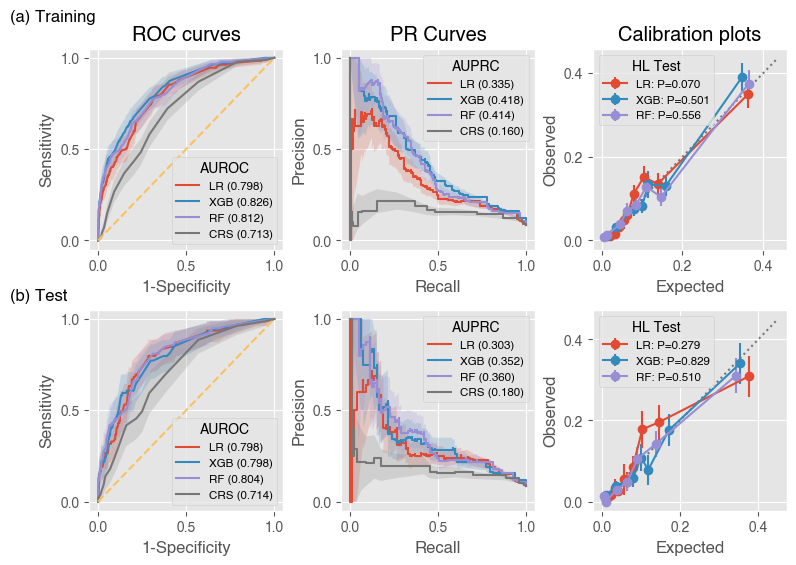

In [107]:
# combine models
model_show_list = ['LR', 'XGB', 'RF', 'CRS']

fig, axes = plt.subplots(2, 3, figsize=(9, 6), facecolor='white')
### ROC 
ax0, ax1 = axes[0, 0], axes[1, 0]

for _model in model_show_list:
    _metric = group_metrics_train.model_metrics_[_model]
    _metric.plot_roc(ax=ax0)

for _model in model_show_list:
    _metric = group_metrics_test.model_metrics_[_model]
    _metric.plot_roc(ax=ax1)

ax0.plot([0, 1], [0, 1], '--')
ax1.plot([0, 1], [0, 1], '--')

tick_array = np.array([0, 0.5, 1])
ax0.set(xlabel='1-Specificity', ylabel='Sensitivity', xticks=tick_array, yticks=tick_array)
ax1.set(xlabel='1-Specificity', ylabel='Sensitivity', xticks=tick_array, yticks=tick_array)

ax0.legend(fontsize='small', title='AUROC')
ax1.legend(fontsize='small', title='AUROC')
ax0.set_title('ROC curves')

ax0.text(-.5, 1.2, '(a) Training', fontdict={'size': 12, 'weight': 'bold'})
ax1.text(-.5, 1.1, '(b) Test', fontdict={'size': 12, 'weight': 'bold'})

### PRC
ax0, ax1 = axes[0, 1], axes[1, 1]

for _model in model_show_list:
    _metric = group_metrics_train.model_metrics_[_model]
    _metric.plot_prc(ax=ax0)

for _model in model_show_list:
    _metric = group_metrics_test.model_metrics_[_model]
    _metric.plot_prc(ax=ax1)

tick_array = np.array([0, 0.5, 1])
ax0.set(xlabel='Recall', ylabel='Precision', xticks=tick_array, yticks=tick_array)
ax1.set(xlabel='Recall', ylabel='Precision', xticks=tick_array, yticks=tick_array)

ax0.legend(fontsize='small', title='AUPRC')
ax1.legend(fontsize='small', title='AUPRC')
ax0.set_title('PR Curves')

### Calibration
ax0, ax1 = axes[0, 2], axes[1, 2]

plot_calibration(
    ax0, 
    {'LR': lr_calib_res_train, 'XGB': xgb_calib_res_train, 'RF': rf_calib_res_train},
    show_pval='legend'
)

plot_calibration(
    ax1, 
    {'LR': lr_calib_res, 'XGB': xgb_calib_res, 'RF': rf_calib_res},
    show_pval='legend'
)

tick_array = np.array([0, 0.2, 0.4])
ax0.set(xlabel='Expected', ylabel='Observed', xticks=tick_array, yticks=tick_array)
ax1.set(xlabel='Expected', ylabel='Observed', xticks=tick_array, yticks=tick_array)

ax0.legend(fontsize='small', title='HL Test', loc='upper left')
ax1.legend(fontsize='small', title='HL Test', loc='upper left')

ax0.set_title('Calibration plots')

### adjust and save
fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.savefig(
    os.path.join(work_dir, 'roc_prc_calib.pdf'),
    bbox_inches='tight'
)

fig.savefig(
    os.path.join(work_dir, 'roc_prc_calib.jpg'),
    bbox_inches='tight', dpi=300
)

fig.show()

## Figure 3: DCA 

In [26]:
from evaluation.dca import calc_net_benefit

In [27]:

model_pred_test = predict_test[['LR', 'RF_Calib', 'XGB_Calib', 'Caprini_Calib']].copy()
model_pred_test.columns = ['LR', 'RF', 'XGB', 'CRS']


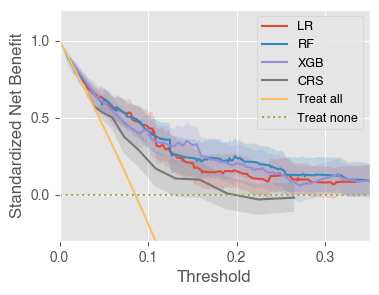

In [106]:
fig, ax = plt.subplots(figsize=(4, 3.), facecolor='white')

dca_values = plot_dca_curves(
    y_test, model_pred_test, ax,
    standardize=True, with_bootstrap=True, n_boot=5000, n_jobs=-1
)
ax.set_xlim(0, 0.35)
ax.set_ylim(-0.3, 1.2)
ax.set_xticks([0, 0.1, 0.2, 0.3])
ax.set_yticks([0, 0.5, 1])
ax.legend(loc='upper right', fontsize=9)

fig.savefig(
    os.path.join(work_dir, 'dca_curves.pdf'), bbox_inches='tight'
)
fig.savefig(
    os.path.join(work_dir, 'dca_curves.jpg'), bbox_inches='tight', dpi=300
)

plt.show()

# Shap

In [109]:
task_df = load_pickle(os.path.join(work_dir, 'task_4d_caprini_df.pkl'))
train_index, test_index = task_df.loc[task_df.dataset == 'train'].index, task_df.loc[task_df.dataset == 'inner_test'].index

rf1 = rf_components['rf1']
feats_rf = rf_components['features_rf1']
rf_test = task_df.loc[test_index, feats_rf].copy()
rf_train = task_df.loc[train_index, feats_rf].copy()

feats_rf_mapped = [caprini_feats_map[_x] for _x in feats_rf]
rf_test.columns = feats_rf_mapped
rf_train.columns = feats_rf_mapped

rf_explainer = load_pickle(os.path.join(work_dir, 'rf', 'shap_explainer.pkl'))
rf_shap_values = rf_explainer.shap_values(rf_test)
rf_shap_values_train = rf_explainer.shap_values(rf_train)

## Figure 4: SHAP plot

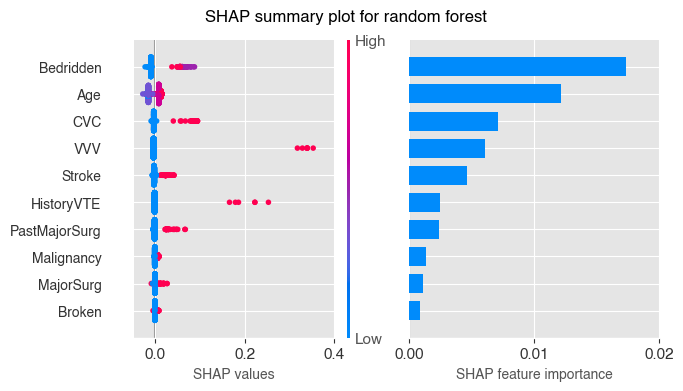

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), facecolor='white')
ax0, ax1 = axes

plt.sca(ax0)

shap.summary_plot(
    rf_shap_values[1], rf_test, max_display=10,
    plot_size=(4, 5),
    color_bar_label='',
    show=False
)
plt.xlabel('SHAP values', fontsize=10)
ax0.set_xticks([0, 0.2, 0.4])
ax0.yaxis.set_tick_params(labelsize=10)

plt.sca(ax1)
ax1.yaxis.set_tick_params(labelsize=10)
shap.summary_plot(
    rf_shap_values[1], rf_test, plot_type="bar", max_display=10,
    # plot_size=(4, 5),
    show=False
)
plt.xlabel('SHAP feature importance', fontsize=10)
ax1.set_xticks([0, 0.01, 0.02])
ax1.set_yticklabels([])

fig.set_size_inches(6.5, 3.5)
fig.suptitle('SHAP summary plot for random forest', y=1.05, fontsize=12)
fig.subplots_adjust(wspace=0.1)

fig.savefig(os.path.join(work_dir, 'shap_rf.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(work_dir, 'shap_rf.jpg'), bbox_inches='tight', dpi=300)

plt.show()
plt.close()

# Risk stratification

In [ ]:
risk_stat = load_pickle(os.path.join(work_dir, 'risk_stratification.pkl'))
risk_stat_test, risk_stat_train = risk_stat['test'], risk_stat['train']
del risk_stat


In [ ]:
risk_stat_test.index.name = 'level'
risk_stat_test.reset_index(inplace=True)
risk_stat_test['level'] = risk_stat_test['level'].map({'Low': 'Low', 'Median': 'Moderate', 'High': 'High'})
risk_stat_test['model'] = risk_stat_test['model'].map(
    {'Caprini': 'CRS', 'RandomForest': 'RF', 'XGBoost': 'XGB'}
)
risk_stat_test


,level,pos_rate,level_count,level_proportion,pos_count,neg_count,model
0,Low,0.024129,373.0,0.403680,9.0,364.0,CRS
1,Moderate,0.089147,258.0,0.279221,23.0,235.0,CRS
2,High,0.160410,293.0,0.317100,47.0,246.0,CRS
3,Low,0.020833,480.0,0.519481,10.0,470.0,RF
4,Moderate,0.065217,184.0,0.199134,12.0,172.0,RF
5,High,0.219231,260.0,0.281385,57.0,203.0,RF
6,Low,0.024145,497.0,0.537879,12.0,485.0,XGB
7,Moderate,0.082474,194.0,0.209957,16.0,178.0,XGB
8,High,0.218884,233.0,0.252165,51.0,182.0,XGB


### Figure 5: Stratification results

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


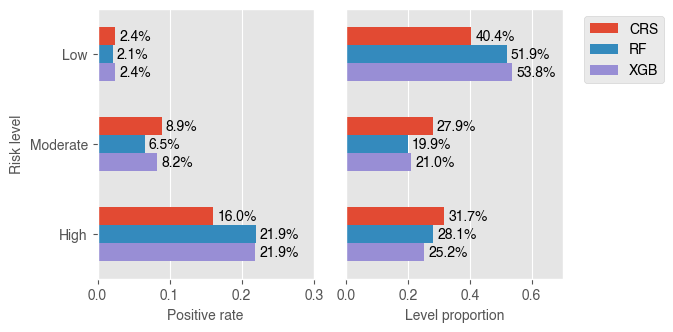

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3.5), facecolor='white')
ax0, ax1 = axes[: 2]

risk_stat_test_grp = risk_stat_test.groupby(by='model')

### ax0
ax = sns.barplot(
    data=risk_stat_test, 
    y='level', x='pos_rate', 
    hue='model', ax=ax0, saturation=1, width=0.6, 
    orient='h'
)
for _container in ax.containers:
    ax.bar_label(
        _container, padding=3,
        labels=risk_stat_test_grp.get_group(_container.get_label())['pos_rate'].apply(lambda x: '{:.1%}'.format(float(x)))
    )

ax0.set_ylabel('Risk level', fontsize=10)
ax0.set_xlabel('Positive rate', fontsize=10)
ax0.set_xlim(left=0.0, right=0.3)
ax0.set_xticks([0, 0.1, 0.2, 0.3])

ax0.get_legend().remove()

### ax1
ax = sns.barplot(
    data=risk_stat_test, 
    y='level', x='level_proportion', 
    hue='model', ax=ax1, saturation=1, width=0.6, orient='h'
)

ax1.set_ylabel('')
ax1.set_yticks([])
ax1.set_xlabel('Level proportion', fontsize=10)
ax1.set_xlim(left=0.0, right=0.7)
ax1.set_xticks([0, 0.2, 0.4, 0.6])

for _container in ax.containers:
    ax.bar_label(
        _container, padding=3, 
        labels=risk_stat_test_grp.get_group(_container.get_label())['level_proportion'].apply(lambda x: '{:.1%}'.format(float(x)))
    )

ax1.legend(loc=0, bbox_to_anchor=(1.5, 1))
fig.subplots_adjust(wspace=0.15)

fig.savefig(os.path.join(work_dir, 'fig_tab', 'compare_risk_level2.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(work_dir, 'fig_tab', 'compare_risk_level2.jpg'), bbox_inches='tight', dpi=300)

fig.show()

In [ ]:
risk_stat_test_grp = risk_stat_test.groupby(by='model')
risk_stat_test_grp.get_group('CRS')

,level,pos_rate,level_count,level_proportion,pos_count,neg_count,model
0,Low,0.024129,373.0,0.403680,9.0,364.0,CRS
1,Moderate,0.089147,258.0,0.279221,23.0,235.0,CRS
2,High,0.160410,293.0,0.317100,47.0,246.0,CRS


## NRI

In [ ]:
risk_strat_details = load_pickle(os.path.join(work_dir, 'risk_stratification_details.pkl'))
risk_strat_train_details, risk_strat_test_details, risk_strat_cutoff = \
    risk_strat_details['train'], risk_strat_details['test'], risk_strat_details['cutoff']
del risk_strat_details

### RF vs Caprini

In [ ]:
strat_map = {'Low': 'Low', 'Median': 'Moderate', 'High': 'High'}
crosstab_pos = pd.crosstab(
    risk_strat_test_details.loc[y_test == 1, 'Caprini'].map(strat_map),
    risk_strat_test_details.loc[y_test == 1, 'RF_Calib'].map(strat_map),
)
crosstab_neg = pd.crosstab(
    risk_strat_test_details.loc[y_test == 0, 'Caprini'].map(strat_map),
    risk_strat_test_details.loc[y_test == 0, 'RF_Calib'].map(strat_map),
)

nri_rf = calc_nri(crosstab_pos, crosstab_neg, alternative='two_sided', return_each_class=True)


In [ ]:
reclassif_rf_df = pd.DataFrame(
    pd.concat([crosstab_pos, crosstab_neg], axis=1).values,
    columns=pd.MultiIndex.from_product(
        [
            ['Positive', 'Negative'],
            ['Low', 'Moderate', 'High']
        ],
        names=['Group', 'Level']
    ),
    index=crosstab_pos.index.values
)


### XGB vs Caprini

In [ ]:
crosstab_pos = pd.crosstab(
    risk_strat_test_details.loc[y_test == 1, 'Caprini'].map(strat_map),
    risk_strat_test_details.loc[y_test == 1, 'XGB_Calib'].map(strat_map),
)
crosstab_neg = pd.crosstab(
    risk_strat_test_details.loc[y_test == 0, 'Caprini'].map(strat_map),
    risk_strat_test_details.loc[y_test == 0, 'XGB_Calib'].map(strat_map),
)

nri_xgb = calc_nri(crosstab_pos, crosstab_neg, alternative='two_sided', return_each_class=True)


In [ ]:
reclassif_xgb_df = pd.DataFrame(
    pd.concat([crosstab_pos, crosstab_neg], axis=1).values,
    columns=pd.MultiIndex.from_product(
        [
            ['Positive', 'Negative'],
            ['Low', 'Moderate', 'High']
        ],
        names=['Group', 'Level']
    ),
    index=crosstab_pos.index.values
)


### SubTable 4: reclassification

In [ ]:
reclassif_df = pd.concat(
    [
        pd.DataFrame(np.nan, columns=reclassif_rf_df.columns, index=['RF vs CRS']),
        reclassif_rf_df, 
        pd.DataFrame(np.nan, columns=reclassif_xgb_df.columns, index=['XGB vs CRS']),
        reclassif_xgb_df
    ], 
    axis=0
)
reclassif_df

Group      Positive                Negative                
Level           Low Moderate  High      Low Moderate   High
RF vs CRS       NaN      NaN   NaN      NaN      NaN    NaN
Low             7.0      1.0   1.0    357.0      0.0    7.0
Moderate        3.0     11.0   9.0     71.0    132.0   32.0
High            0.0      0.0  47.0     42.0     40.0  164.0
XGB vs CRS      NaN      NaN   NaN      NaN      NaN    NaN
Low             7.0      1.0   1.0    352.0     11.0    1.0
Moderate        6.0     11.0   6.0     94.0    114.0   27.0
High            2.0      1.0  44.0     56.0     36.0  154.0

In [ ]:
nri_results = {
    'reclassification': reclassif_df,
    'nri_rf': nri_rf,
    'nri_xgb': nri_xgb
}
save_dataframe_dict(
    nri_results,
    os.path.join(work_dir, 'fig_tab', 'nri_results.xlsx')
)